# BEFORE CRAWLING

In [9]:
# module 
from selenium import webdriver
import time
import pandas as pd
import re
from konlpy.tag import Okt
import networkx as nx
from matplotlib.pyplot import figure

# 크롬 웹브라우저 실행
driver = webdriver.Chrome()
url_list = []
content_list = ""

text = "한샘 인테리어"  # input text!
 
for i in range(1, 30):  
    url = 'https://section.blog.naver.com/Search/Post.nhn?pageNo='+ str(i) + '&rangeType=ALL&orderBy=sim&keyword=' + text
    driver.get(url)
    time.sleep(0.5)
 
    for j in range(1, 5): 
        titles = driver.find_element_by_xpath('/html/body/ui-view/div/main/div/div/section/div[2]/div['+str(j)+']/div/div[1]/div[1]/a[1]')
        title = titles.get_attribute('href')
        url_list.append(title)
 
print("url 수집 끝, 해당 url 데이터 크롤링")
 
for url in url_list: # 수집한 url 만큼 반복
    driver.get(url) # 해당 url로 이동
    driver.switch_to.frame('mainFrame')
    overlays = ".se-component.se-text.se-l-default" # 내용 크롤링
    contents = driver.find_elements_by_css_selector(overlays)
 
    for content in contents:
        content_list = content_list + content.text # content_list 라는 값에 + 하면서 점점 누적

content_list = re.compile('[^ ㄱ-ㅣ가-힣+]').sub(" ", content_list) # 한글말고 제거
content_list =  re.sub(' +', ' ', content_list) # 이중 띄어쓰기 제거

okt = Okt()
hansam = okt.nouns(content_list)  # 명사 리스트 추가 
hansam = pd.DataFrame(hansam) # 추가된 명사 리스트 데이터 프레임화
hansam.head() # for wordcloud dict(hansma['0'])으로 넣어주면 됨.
hansam.to_csv('hansam_house.csv', index=False) #저장
print("END CRAWLING")

KeyboardInterrupt: 

In [ ]:
# AFTER CRAWLING

In [12]:
net_hansam

,target
0,서점
1,마음
2,달서구
3,서점
4,부분
...,...
636,완성
637,구상
638,경산
639,경산


In [14]:
hansam = pd.read_csv('hansam_house.csv')
hansam = hansam[hansam['0'].apply(lambda x : len(x)) > 1] # 한글자 단어는 제거 (불용어 사전이 있으면 적용해주면 좋지만.. 귀찬)
hansam = hansam.reset_index(drop=True)

net_hansam = pd.DataFrame() # net_hansam 이라는 network 용 프레임 저장
net_hansam['target'] = hansam.loc[(hansam[hansam['0'] == '인테리어'].index)+1]['0'].to_list() # 처음에만 target이 먼저와야함 길이 떄문
                                                                                            # index )+1 인테리어 다음 단어가 먼지net_hansam['source'] = '인테리어' # 중심으로 보고 싶은 단어 여기에
net_hansam['source']  = '인테리어'
net_hansam = net_hansam[['source', 'target']]

In [15]:
net_hansam.head()

,source,target
0,인테리어,서점
1,인테리어,마음
2,인테리어,달서구
3,인테리어,서점
4,인테리어,부분


In [16]:
# 한 단어 다음에 있는 단어랑 관계도 짜기
real_df = pd.DataFrame()
for i in net_hansam['target'].value_counts()[:10].keys(): # 인테리어 다음 나오는 target 단어 중 가장 많이 나온 단어 10개 추출
    tmp_df = pd.DataFrame()
    tmp_df['target'] = hansam.loc[(hansam[hansam['0'] == i].index)+1]['0'].to_list() # target 단어가 source 가 되고 
                                                                                     # TARGET 다음 단어가 또 다른 target이됨
    tmp_df['source'] = i
    real_df = pd.concat([tmp_df, real_df])
net_hansam = pd.concat([net_hansam, real_df], 0) # net_hansam에 또 추가

In [17]:
sub_df = real_df # sub network 형성 네트워크 확장을 위해

real_df = pd.DataFrame()
for i in sub_df['target'].value_counts()[:10].keys():
    tmp_df = pd.DataFrame()
    tmp_df['target'] = hansam.loc[(hansam[hansam['0'] == i].index)+1]['0'].to_list()
    tmp_df['source'] = i
    real_df = pd.concat([tmp_df, real_df])
net_hansam = pd.concat([net_hansam, real_df], 0)

In [18]:
sub_df = real_df # 한번 더 확장

real_df = pd.DataFrame()
for i in sub_df['target'].value_counts()[:10].keys():
    tmp_df = pd.DataFrame()
    tmp_df['target'] = hansam.loc[(hansam[hansam['0'] == i].index)+1]['0'].to_list()
    tmp_df['source'] = i
    real_df = pd.concat([tmp_df, real_df])
net_hansam = pd.concat([net_hansam, real_df], 0)

In [19]:
# net_net : real dataframe for network! 
net_net = pd.DataFrame(net_hansam.value_counts()).reset_index() #만들어진 net_hansam에서 value_counts 더한것
net_net = net_net.rename(columns = {0 : 'weight'})
net_net = net_net[net_net['weight'] > 20] # 너무 많은 가지가 보이면 어려우니깐 반복 빈도가 높은 녀석들 나는 기준을 20으로 지정
net_net= net_net[net_net['source'] != net_net['target']] # 같은 단어가 두번 반복 되는 경우 피하기

In [20]:
net_net['type'] = pd.Categorical(net_net['source']) # 지금은 필요 없는 코드

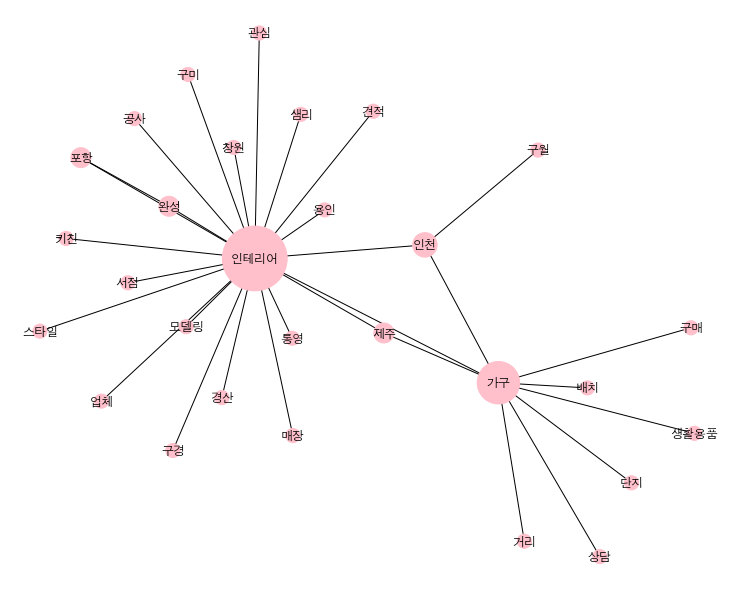

In [25]:
# https://towardsdatascience.com/customizing-networkx-graphs-f80b4e69bedf 참고 

G = nx.Graph()

G = nx.from_pandas_edgelist(net_net, 'source', 'target', ['weight'])
d = dict(G.degree)
figure(figsize=(10, 8))

# Specify colors
nx.draw(G, 
        with_labels=True, 
        font_family='AppleGothic', node_size=[v * 200 for v in d.values()],
        font_size= 12,
        node_color = 'pink')
plt.savefig("Graph.png", format="PNG")
